In [1]:
#from ultralytics import YOLO
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

import comet_ml

import json
import os
from PIL import Image
import shutil
import copy

In [2]:
import sys

ultralytics_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked'
sys.path.append(ultralytics_dir)

from ultralytics import YOLO

## To Do

- Optimize Parameters:
    - Image Size (640, 960, 1280) by multiples of 32
    - Freezing Layers ( [0, 22], [0, 10], [0, 15]  )
    - Batch Normalization params frozen vs unfrozen
    - single_cls = True vs False

- Compare with models:
    - YOLO baseline without image preprocessing or finetuning
    - YOLO after image preprocessing and finetuning
    - SSD (fast but less accurate) and Faster R-CNN (slow but more accurate)
    
- Debug non-normalized annots
- Find a simple module (like a blob detector) that can be put before the YOLO model.  
    One idea is to do a Spatial Pyriamid Convolution (not pooling), where you take the image, create a few feature maps by running it through different kernel size, giving a fixed image output, which is then used as an input to the model.
    
    Another idea is to use a pretrained blob detector, and input this (or maybe add this to the og image) to the model.


## Done
- Normalize annotations using the correct image shapes
- Check how the training data and labels should be given to the YOLO model.
- Freezing Layers
- Check if the model resizes image to a standard size.  If so, shouldn't SPPF layer take care of it?
- Load the model using the yaml file.
- Decreased precision of annotations to 4 decimals.  Model training is much quicker.  Previously took >2 mins for 1 epoch, now around 30 seconds.
- Find how to add in an initial module.


- Turned on single class, then we trained the model only on the face data, which is labelled as class 80, and the bounding box only covers the head.  But we see something interesting happening.  The model learns to give good predictions for the BBox, however it missclassifies the preds to be of class 0 (which is person), even though the training data didn't contain any class zeros.  There can be a few reasons for this:
    
    Since we constrain the training to a single class (through the argument singlecls = True), the model decides on the class 0, probably because it has a massive training bias towards that class.  Once it fixates on this class (person/0), the only other way it can minize the collective loss is to deal with the BBox loss.  Since it has already been training in similar situations to recognize faces as persons, and owing to the variability in predicting BBoxes, it is flexible enough to redirect its box predictions from the whole body to just the face.  This can be seen as a task for Visually Related object Detection (VRoD), where we try to fine-tune the model to detect a visually similar class to a pre-existing class.

- We tried two different things:
    - Adding a new label: The model didn't recognize the label, it classifies it to background.  It doesn't assign any instrinsic meaning to the label, therefore, the model is confused by a new label, no matter how similar the new label is to a pre-existing label.  
    - Using head bbox: We fail to predict head bbox because the person bbox (which the model is trained on, and which it uses as a starting point) has a different centre than a head bbox.  As centres are used to assign the task of detection to a certain grid cell, we see that the respective centres don't fall into the same grid cells.  This would make the initial model predictions to be false positives, which would then put these predictions as the 'background' class, instead of the desired 'face' class.

-----------

## Preprocessing Data

In [3]:
#Parent directory for data
data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data'

#Directories for original data, and data formatted for YOLO
ch_data_dir = data_dir + r'\CrowdHuman'
yolo_ch_data_dir = data_dir + r'\yolo_CrowdHuman'

#Original Data for images
train_dir = ch_data_dir + r'\CrowdHuman_train01\Images'
val_dir = ch_data_dir + r'\CrowdHuman_val\Images'
test_dir = ch_data_dir + r'\CrowdHuman_test\images_test'

#Original Data for annotations
val_annot_odgt = ch_data_dir + r'\annotation_val.odgt'
train_annot_odgt = ch_data_dir + r'\annotation_train.odgt'

#Original Image shapes data
train_shapes_path = data_dir + r'\train_img_shapes.txt'
val_shapes_path = data_dir + r'\val_img_shapes.txt'

#YOLO formatted Training annotations
train_annot_body_dir = yolo_ch_data_dir + r'\train_annots_body'
train_annot_face_dir = yolo_ch_data_dir + r'\train_annots_face'
train_annot_both_dir = yolo_ch_data_dir + r'\train_annots_both'

#YOLO formatted Validation annotations
val_annot_body_dir = yolo_ch_data_dir + r'\val_annots_body'
val_annot_face_dir = yolo_ch_data_dir + r'\val_annots_face'
val_annot_both_dir = yolo_ch_data_dir + r'\val_annots_both'


#YOLO formatted data directory (only body)
data_body_dir = data_dir + r'\yolo_data_body'
data_body_yaml = data_dir + r'\data_body_meta.yaml'

#YOLO formatted data directory (only face)
data_face_dir = data_dir + r'\yolo_data_face'
data_face_yaml = data_dir + r'\data_face_meta.yaml'

#YOLO formatted data directory (both body and face)
data_both_dir = data_dir + r'\yolo_data_both'
data_both_yaml = data_dir + r'\data_both_meta.yaml'

#test_annot_dir = data_dir + r'\test_annot'
#test_shapes_path = data_dir + r'\test_img_shapes.txt'

#### Obtaining Image Shapes

In [18]:
#Obtain list of image shapes from text file, if file does not exist, create the text file
# data_dir: Parent Directory
# shapes_txt: Name of text file to save at
# mode_dir: Type of file (train/val/test)
def get_img_shapes(data_dir, shapes_txt, mode_dir): 

    #Path for the text file
    shapes_path = data_dir + r'\\' + shapes_txt

    #Obtains the image path using the image id
    get_img_path = lambda img_id: ''.join([mode_dir, r'\\', img_id])

    #Obtains the image size using the image id
    #Returns (Image ID, Image Shape): Image Shape = (width, height)
    get_img_shape = lambda img_id: (img_id, Image.open(get_img_path(img_id)).size)

    #Saving to text file
    if shapes_txt not in os.listdir(data_dir):
        print('\nCreating Text File...')
        #Gets image shape for each image in directory
        img_shapes = list(map(get_img_shape, os.listdir(mode_dir)))

        with open(shapes_path, 'w') as f:
            for img_meta in img_shapes:
                f.write(f'{img_meta} \n')
        
        print('Created Text file.\n')


    #Reads the file, extracting the lines
    print('Reading Text File...')
    with open(shapes_path, 'r') as f:
        file_shapes = f.readlines()
    
    #Extracts information from each line (of type string)
    def get_info_from_str(s):
        s = s.strip().split(', ')
        return [s[0][2:-5], float(s[1][1:]), float(s[2][:-2])]

    img_shapes = list(map(get_info_from_str, file_shapes))

    return(img_shapes)

In [19]:
train_img_shapes = get_img_shapes(data_dir, shapes_txt = r'train_img_shapes.txt', mode_dir = train_dir)
val_img_shapes = get_img_shapes(data_dir, shapes_txt = r'val_img_shapes.txt', mode_dir = val_dir)
test_img_shapes = get_img_shapes(data_dir, shapes_txt = r'test_img_shapes.txt', mode_dir = test_dir)

Reading Text File...
Reading Text File...
Reading Text File...


In [6]:
# train_img_shapes[:5]

#### Annotations from .odgt to .txt

In [20]:
def convert_to_yolo_format(box, img_width, img_height, precision = 4):
    """
    Convert bounding box annotation to YOLO format.
    """

    #x_bl, y_bl refers to bottom left corner
    x_bl, y_bl, width, height = box

    x_center = (x_bl + width / 2) / img_width
    y_center = (y_bl + height / 2) / img_height
    width /= img_width
    height /= img_height

    #Decreases the precision to 4 decimal digits to make the model training lighter
    x_center, y_center, width, height = list(map(lambda n: round(n, precision), [x_center, y_center, width, height]))
    
    return x_center, y_center, width, height

In [21]:
def process_annotations(odgt_file, output_dir, img_shapes, bbox_mode):

    output_dir = output_dir + '_' + bbox_mode

    #Create directory
    if not os.path.exists(output_dir): os.makedirs(output_dir)

    #Get image ids using the img_shapes list ([Image ID, Image Shape])
    img_ids = [meta[0] for meta in img_shapes]

    #Read annotation file
    with open(odgt_file, 'r') as f:
        lines = f.readlines()

    #Iterate through each line, which contains the json formatted info for each image
    for line in lines:
        annotation = json.loads(line)   #Get the JSON formatted annotation
        image_id = annotation['ID']     #Image ID
        objects = annotation['gtboxes'] #Bounding Boxes

        if image_id not in img_ids: continue    #Filtering out unnecessary training samples

        img_index = img_ids.index(image_id)     #Get index of the required image
        img_width, img_height = img_shapes[img_index][1], img_shapes[img_index][2]  #Get shape of required image
        
        yolo_labels = []
        for obj in objects:
            
            # Skip ignored boxes
            if obj['extra'].get('ignore', 0) == 1: continue

            # Assuming the class label for the body bounding box is 0
            # and the class label for the face bounding box is 1
            body_box = obj['vbox']  # Visible bounding box
            face_box = obj['hbox']  # Head bounding box
            
            #Convert to yolo format
            body_yolo = convert_to_yolo_format(body_box, img_width, img_height)
            face_yolo = convert_to_yolo_format(face_box, img_width, img_height)

            #Append annots to yolo_labels
            if bbox_mode == 'face':  yolo_labels.append((0, *face_yolo))    #Class 80 for face
            elif bbox_mode == 'body': yolo_labels.append((0, *body_yolo))    #Class 0 for body
            elif bbox_mode == 'both':
                yolo_labels.append((0, *body_yolo))
                yolo_labels.append((0, *face_yolo))
            else:
                return('Invalid entry for mode.  Only accepted values: ["face", "body", "both"]')

        # Write YOLO format annotations to file
        label_filename = os.path.join(output_dir, f"{image_id}.txt")
        with open(label_filename, 'w') as out_f:
            for label in yolo_labels:
                out_f.write(" ".join(map(str, label)) + '\n')

In [22]:
# Convert training annotations to folder with annotated text files
idgt_file = train_annot_odgt
output_dir = yolo_ch_data_dir + r'\train_annots'

process_annotations(idgt_file, output_dir, train_img_shapes, bbox_mode = 'body')

In [23]:
# Convert validation annotations to folder with annotated text files
idgt_file = val_annot_odgt
output_dir = yolo_ch_data_dir + r'\val_annots'

process_annotations(idgt_file, output_dir, val_img_shapes, bbox_mode = 'body')

In [11]:
# len(os.listdir(val_dir))

In [12]:
# len(os.listdir(val_annot_both_dir))

#### Plotting Image

In [13]:
# #Get sample image
# image_ind = 15

# sample_img_file = os.listdir(train_dir)[image_ind]
# sample_img_path = train_dir + fr'\{sample_img_file}'
# sample_img = cv2.imread(sample_img_path)
# print(sample_img.shape)

# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [14]:
# #Get the bounding boxes
# sample_img_id = sample_img_file[:-4]
# sample_annot_path = train_annot_face_dir + f'\{sample_img_id}.txt'

# with open(sample_annot_path, 'r') as f:
#     sample_annots = f.readlines()

In [15]:
# #Get shape of image
# img_ids = [meta[0] for meta in train_img_shapes]
# sample_ind = img_ids.index(sample_img_id)
# sample_img_shape = train_img_shapes[sample_ind][1:]
# sample_img_shape

In [16]:
# #Get bounding boxes (both visible and face boxes)
# get_info = lambda s: [float(val) for val in s.strip().split(' ')[1:]]
# sample_img_bboxs = list(map(get_info, sample_annots))

# sample_img_bboxs[1]

In [17]:
# #Obtain the plotting coords using the bounding box values
# def get_plt_coords(bbox, img_width = None, img_height = None):
#     x, y, w, h = bbox

#     if img_width and img_height:
#         x, y, w, h = x*img_width, y*img_height, w*img_width, h*img_height

#     #x, y are centered
#     return([[[x - w/2, x + w/2], [y - h/2, y - h/2]],
#             [[x - w/2, x + w/2], [y + h/2, y + h/2]],
#             [[x - w/2, x - w/2], [y - h/2, y + h/2]],
#             [[x + w/2, x + w/2], [y - h/2, y + h/2]]])

In [18]:
# coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img_shape[0], sample_img_shape[1]), sample_img_bboxs))
# np.shape(coords)

In [19]:
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# for coord in coords:
#     for c in coord:
#         plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

#### Creating dirs in YOLO format

In [5]:
n_train, n_val = 150, 20

In [6]:
def shift_files(source_dir, dest_dir, n_files, data_image, mode_train):

    #If data files is images or annotations
    if data_image: dest_dir += r'\images'
    else: dest_dir += r'\labels'

    #If data files is for training or validation
    if mode_train: dest_dir += r'\train'
    else: dest_dir += r'\val'

    # #If data files is for training or validation
    # if mode_train: dest_dir += r'\train'
    # else: dest_dir += r'\val'

    # #If data files is images or annotations
    # if data_image: dest_dir += r'\images'
    # else: dest_dir += r'\labels'

    #Creates destination directory (overwrites if exists)
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    #Gets files to shift
    shift_files = os.listdir(source_dir)[:n_files]

    #Copies files from source to destination
    for file_name in shift_files:
        file_path = os.path.join(source_dir, file_name)

        if os.path.isfile(file_path):
            shutil.copy(file_path, dest_dir)

    dest_dir_split = dest_dir.split('\\')
    print(f'Finished Copying {n_files} {dest_dir_split[-1]} {dest_dir_split[-2]}')

In [7]:
#For only body annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_body_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_body_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_body_dir, dest_dir = data_body_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_body_dir, dest_dir = data_body_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 150 train images
Finished Copying 20 val images
Finished Copying 150 train labels
Finished Copying 20 val labels


In [20]:
#For only face annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_face_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_face_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_face_dir, dest_dir = data_face_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_face_dir, dest_dir = data_face_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 10 train images
Finished Copying 5 val images
Finished Copying 10 train labels
Finished Copying 5 val labels


In [24]:
# #For both body and face annotations

# #Create images folder with train, val directories, and shift n_files in there
# shift_files(source_dir = train_dir, dest_dir = data_both_dir, n_files = n_train, data_image = True, mode_train = True)
# shift_files(source_dir = val_dir, dest_dir = data_both_dir, n_files = n_val, data_image = True, mode_train = False)

# #Create labels folder with train, val directories, and shift n_files in there
# shift_files(source_dir = train_annot_both_dir, dest_dir = data_both_dir, n_files = n_train, data_image = False, mode_train = True)
# shift_files(source_dir = val_annot_both_dir, dest_dir = data_both_dir, n_files = n_val, data_image = False, mode_train = False)

#### Plotting YOLO formatted data

In [25]:
# sample_ind = 3

# sample_img_path = data_face_dir + r'\images\train'
# sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
# sample_img = cv2.imread(sample_img_path)

# sample_label_path = data_face_dir + r'\labels\train'
# sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

# with open(sample_label_path, 'r') as f:
#     sample_label = f.readlines()

In [26]:
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [27]:
# conv_to_floats = lambda row: [float(elem) for pos, elem in enumerate(row.strip().split(' ')) if pos != 0]

# sample_label = list(map(conv_to_floats, sample_label))
# coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img.shape[1], sample_img.shape[0]), sample_label))

In [28]:
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# for coord in coords:
#     for c in coord:
#         plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

## YOLOv8

In [3]:
# Load the pretrained YOLOv8 model
#model = YOLO('yolov8n.pt')

model_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n.yaml'
weights_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\Vision_Project\yolov8n.pt'

coco8_yaml = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\datasets\coco8.yaml'

#model = YOLO(model_dir).load(weights_dir)
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

Transferred 355/355 items from pretrained weights


#### Sample Run

In [30]:
# # Load an image
# image_path = 'test_image.jpeg'
# image = cv2.imread(image_path)

# # Perform inference
# results = model(image)

In [31]:
# img_annot = results[0].plot()
# plt.imshow(cv2.cvtColor(img_annot, cv2.COLOR_BGR2RGB))
# #plt.show()

In [32]:
# # Access detection results

# box_dims = {}

# for result in results:
#     boxes = result.boxes
#     for n_box, box in enumerate(boxes):
#         x1, y1, x2, y2 = box.xyxy[0]
#         confidence = box.conf[0]
#         class_id = box.cls[0]
#         print(f"Class ID: {class_id}, Confidence: {confidence}, BBox: [{x1}, {y1}, {x2}, {y2}]")

#         box_dims[n_box] = [float(class_id), float(confidence), box.xyxy[0].numpy()]

#### Checking Blob Detection

In [4]:
sample_ind = 3

sample_img_path = data_body_dir + r'\images\train'
sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
sample_img = cv2.imread(sample_img_path)

sample_label_path = data_body_dir + r'\labels\train'
sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

with open(sample_label_path, 'r') as f:
    sample_label = f.readlines()

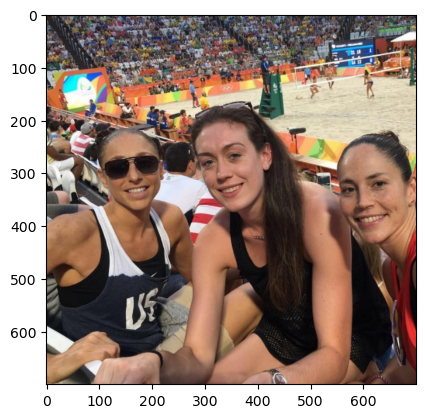

In [5]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

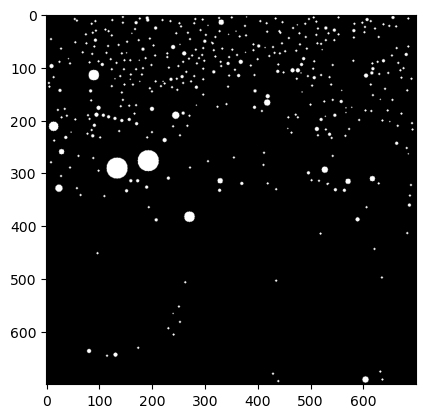

In [7]:
# # Read the image
image = cv2.imread(sample_img_path, cv2.IMREAD_COLOR)

gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set up SimpleBlobDetector parameters
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 10

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.5

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(gray_img)

# Create an empty mask
mask = np.zeros_like(gray_img)

# Draw blobs on the mask
for keypoint in keypoints:
    x, y = np.int64(keypoint.pt)
    r = np.int64(keypoint.size // 2)
    cv2.circle(mask, (x, y), r, (255), -1)


plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()

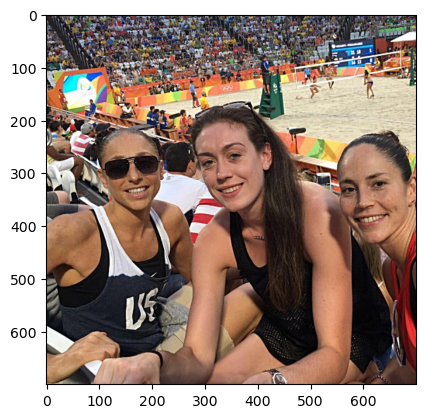

In [11]:
# Sharpen the sample_img using unsharp masking
blurred = cv2.GaussianBlur(sample_img, (9, 9), 10.0)
sharpened = cv2.addWeighted(sample_img, 1.5, blurred, -0.5, 0)

plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
plt.show()

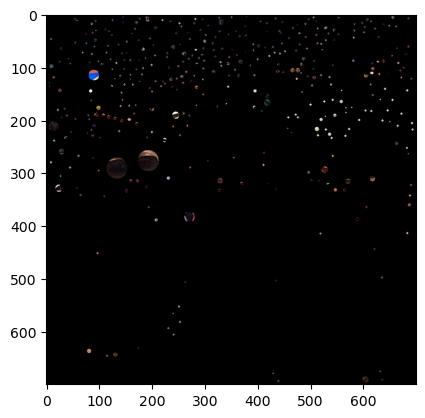

In [17]:
# Split the image into three color channels
sharpened_b, sharpened_g, sharpened_r = cv2.split(sharpened)

# Apply bitwise operations to each color channel
sharp_blobs_b = cv2.bitwise_and(sharpened_b, sharpened_b, mask=mask)
sharp_blobs_g = cv2.bitwise_and(sharpened_g, sharpened_g, mask=mask)
sharp_blobs_r = cv2.bitwise_and(sharpened_r, sharpened_r, mask=mask)

blobs_merge = cv2.merge((sharp_blobs_b, sharp_blobs_g, sharp_blobs_r))

plt.imshow(cv2.cvtColor(blobs_merge, cv2.COLOR_BGR2RGB))
plt.show()

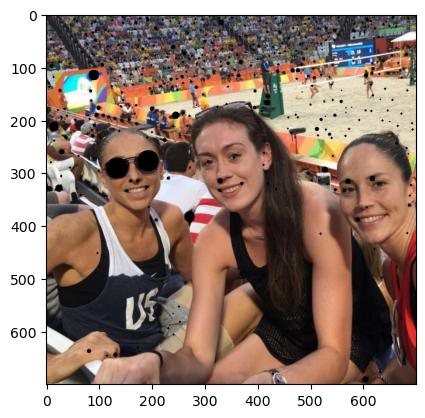

In [18]:
image_b, image_g, image_r = cv2.split(image)

non_sharp_regions_b = cv2.bitwise_and(image_b, image_b, mask=cv2.bitwise_not(mask))
non_sharp_regions_g = cv2.bitwise_and(image_g, image_g, mask=cv2.bitwise_not(mask))
non_sharp_regions_r = cv2.bitwise_and(image_r, image_r, mask=cv2.bitwise_not(mask))

non_sharp_merge = cv2.merge((non_sharp_regions_b, non_sharp_regions_g, non_sharp_regions_r))

plt.imshow(cv2.cvtColor(non_sharp_merge, cv2.COLOR_BGR2RGB))
plt.show()

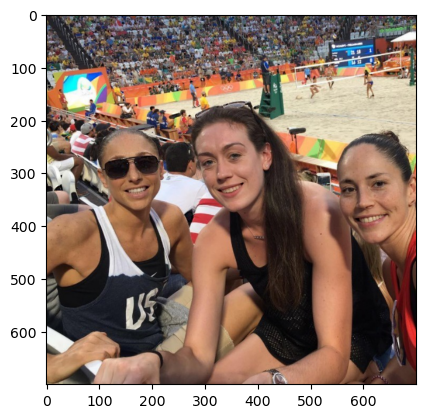

In [19]:
# Combine the sharpened blobs with the non-sharpened regions
result_b = cv2.add(sharp_blobs_b, non_sharp_regions_b)
result_g = cv2.add(sharp_blobs_g, non_sharp_regions_g)
result_r = cv2.add(sharp_blobs_r, non_sharp_regions_r)

# Merge the color channels back into one image
result = cv2.merge((result_b, result_g, result_r))

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

#### Simple Blob Detector

This is a pre-processing method to label the image with relevant blobs as keypoints, in the hope that these capture human faces.  The blob detection is carried out by the SimpleBlobDetector method from the OpenCV package.  We define the desired blobs to be constrained in size (area from 15 to 500), which ensures that persons far away can be labelled.  The faces close by can be easily detected (and thus, doesn't demand labelling), while the persons far away can be hard to detect.  Labelling them can guide the model to detect them better.  We also tune the parameters of circularity, convexity and inertia to make the blobs close to circular but also detect elongated figures (like faces).

In [33]:
# imgs = list(os.listdir(train_dir))

# get_img = lambda ind: cv2.imread(train_dir + r'\\' + imgs[ind])
# plot_img = lambda img: plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# image = get_img(3)
# plot_img(image)

In [34]:
# # Set up the SimpleBlobDetector with default parameters
# params = cv2.SimpleBlobDetector_Params()

# # Change thresholds
# params.minThreshold = 0
# params.maxThreshold = 255

# # Filter by Area.
# params.filterByArea = True
# params.minArea = 15
# params.maxArea = 500

# # Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = 0.53

# # Filter by Convexity
# params.filterByConvexity = True
# params.minConvexity = 0.87

# # Filter by Inertia
# params.filterByInertia = False
# params.minInertiaRatio = 0.01

# # Create a detector with the parameters
# detector = cv2.SimpleBlobDetector_create(params)

# # Convert to grayscale
# #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Detect blobs 
# keypoints = detector.detect(image)

# # Draw detected blobs as red circles
# # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
# im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# # Show keypoints
# plot_img(im_with_keypoints)

In [35]:
def plot_simpledetector(circularity, convexity, inertia):
    # Set up the SimpleBlobDetector with default parameters
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = 255

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 10

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = circularity

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = convexity

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = inertia

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Convert to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect blobs 
    keypoints = detector.detect(image)

    # Draw detected blobs as red circles
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show keypoints
    plot_img(im_with_keypoints)

In [36]:
# from ipywidgets import interact

# interact(plot_simpledetector,
#             circularity = (0.01, 0.9, 0.01),
#             convexity = (0.01, 1, 0.1),
#             inertia = (0.01, 0.5, 0.1))

#### Pre-Model Layer

Three steps:
- Add new module: Create new module for prelayer.  Add it in conv.py, and mention the module name in init.py and tasks.py.
- Create YAML file: This is the configuration file that contains the model architecture and other metadata like number of classes.  Modify the architecture and insert the module, taking care of updating the other module numbers (especially in the 'from' column).
- Create state dict: Define a new and empty state dictionary, add in randomly initialized (and correctly sized) parameters corresponding to the new module.  Then, add in the pre-trained parameters to the state dictionary.  Save this as a .pt file.  When loading call the load_state_dict and torch.load methods to add in the parameters to the loaded model.

Challenges Faced
- Figuring out where to mention the module was challenging.  I had to look at relevant portions of the code documentation, understand it in relation to the rest of the pipeline, and figure out where to mention the module.  
- Creating the YAML file had to be carefully done, as updating the connections between modules was easily missed, and that led to errors.  
- Creating the state dict required updating the model indices and making sure that the parameter tensor sizes were correct.  For this purpose, I defined the get_layer_sizes, which returns the layer sizes for each module in a nicely formatted output.

##### Get Layer Sizes

In [37]:
#Returns the layer sizes in each module as {Module: (layer_name, layer_size)}
def get_layer_sizes(state_dict):

    #Gets layer number given the parameter name
    get_layer_num = lambda name: int(name.split('.')[2])
    n_modules = get_layer_num( list(state_dict.keys())[-1] ) + 1     #Gets total number of modules

    layer_sizes = {}

    #Iterates through each module index
    for module_num in range(n_modules):
        #Gets the param names in a module, and gets the layer sizes for each layer in the module
        param_names = [name for name in state_dict.keys() if get_layer_num(name) == module_num]
        layer_sizes[module_num] = [(param, state_dict[param].shape) for param in param_names]
    
    return(layer_sizes)

In [38]:
# layer_sizes = get_layer_sizes(model.state_dict())
# layer_sizes.keys()

In [39]:
# for k, v in layer_sizes.items():
#     print(f'\n\n Module {k}:')

#     for t in v:
#         print(f'{t[0]}: {t[1]}\n')

##### Defining new state dictionary

In [40]:
# #Defines random tensor for a conv weight parameter
# def rand_conv_weights(in_channels, out_channels, kernel_size):
#     tensor_shape = (out_channels, in_channels, kernel_size[0], kernel_size[0])
#     return torch.rand(tensor_shape)

# #Defines param name in format for state dict, given layer num and individual param name
# get_param_name = lambda layer_num, param_name: f'model.model.{layer_num}.{param_name}.weight'

In [41]:
# #Adds in params for new module
# new_state_dict = {}

# new_state_dict[get_param_name(0, 'conv1')] = rand_conv_weights(in_channels=3, out_channels=5, kernel_size=(3, 3))
# new_state_dict[get_param_name(0, 'conv2')] = rand_conv_weights(in_channels=5, out_channels=3, kernel_size=(3, 3))
# new_state_dict.keys()

In [42]:
# #Adds in pre-trained params
# param_state_dict = model.state_dict()   #State dict for pre-trained model

# for param_name, param_val in param_state_dict.items():
#     module_num = int(param_name.split('.')[2])   #Gets layer number from param name

#     #Updates the param name by adding 1 to module number, as we are adding in a module to the start
#     new_param_name = param_name.replace(f'model.model.{module_num}', f'model.model.{module_num + 1}')

#     #Adds the pre-trained param to new state dict
#     new_state_dict[new_param_name] = param_state_dict[param_name]

In [43]:
# layer_sizes = get_layer_sizes(new_state_dict)
# layer_sizes.keys()

In [44]:
# for k, v in layer_sizes.items():
#     print(f'\n\nModule {k}:')

#     for t in v:
#         print(f'{t[0]}: {t[1]}\n')

In [45]:
# #Saving state dictionary
# torch.save(new_state_dict, 'yolov8n_trial.pt')

##### Running new model with new weights

In [46]:
# model_trial_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n_trial.yaml'
# weights_trial_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\Vision_Project\yolov8n_trial.pt'

In [47]:
# model_trial = YOLO(model_trial_dir, task='detect')
# model_trial.load_state_dict(torch.load(weights_trial_dir))

#### Freezing Layers

<b>Disabling Batch Normalization:</b> When freezing layers, the parameters can get frozen however the batch normalization stats can still update.  This is seen below when comparing the state dicts before and after the training where we froze 22 layers but the bn sections of these frozen layers are still seen to be updating.  To deal with this, we need to define a callback function that disables the tracking of stats.

In [10]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

From the model architecture, we see that the backbone consists of the first 10 layers, the neck consists of the 12 layers after, and the head is the last layer.  This gives a total of 23 layers for the module.

In [5]:
# #Get number of parameters in a layer
# def get_layer_params(layer_num, model):
    
#     params = []
#     for k, v in model.named_parameters():   #Gets (name of param, value of param)
#         if f'model.{layer_num}.' in k:      #Extracts params corresponding to model layer
#             params.append(v)                #Appends layer params to list

#     return(sum([p.numel() for p in params]))    #Returns total number of params in layer

# n_layers = int(list(model.state_dict().keys())[-1].split('.')[2])


# #Gets the number of trainable params after freezing n_freeze layers (freezing from 0 till (n_freeze - 1), the n_freeze layer is not frozen)
# n_params_after_freeze = lambda n_freeze, model: sum(list(map(lambda layer_num: get_layer_params(layer_num, model), np.arange(n_freeze, n_layers + 1))))

# print(f'Total number of parameters: {n_params_after_freeze(0, model)}\n')
# print(f'Trainable params after freezing backbone: {n_params_after_freeze(10, model)}')
# print(f'Trainable params after freezing half of neck: {n_params_after_freeze(15, model)}')
# print(f'Trainable params after freezing neck: {n_params_after_freeze(22, model)}')
# print(f'Trainable params after freezing head: {n_params_after_freeze(23, model)}')

Total number of parameters: 3157200

Trainable params after freezing backbone: 1884544
Trainable params after freezing half of neck: 1736320
Trainable params after freezing neck: 897664
Trainable params after freezing head: 0


In [6]:
# #Freezes layers for fine-tuning
# def freeze_layer(trainer, freeze_layers):

#     model = trainer.model

#     #Prints the layers being frozen
#     print(f'\nFreezing {len(freeze_layers)} layers: \n {freeze_layers}\n')
#     freeze = [f'model.{x}.' for x in freeze_layers]

#     #Iterates through all params
#     for param_name, param in model.named_parameters():
#         param.requires_grad = True  #Sets all params to trainable

#         #Sets params belonging to freeze layers as non-trainable (freezing them)
#         if any(x in param_name for x in freeze):
#             param.requires_grad = False
    
#     print(f'{len(freeze_layers)} layers are freezed')
#     print(f'Total number of trainable parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}\n')

In [7]:
# #Disables tracking batch normalization stats, puts bn layers to eval mode
# def put_layer_in_eval_mode(trainer, freeze_layers):

#     track_layers = []

#     #Gets modules for batch normalization, checks if it belongs to a frozen layer
#     #If so, it puts the module to eval mode and disables bn stats tracking
#     for (name, module) in trainer.model.named_modules():
#         if name.endswith('bn') and int(name.split('.')[1]) in freeze_layers:
#             module.eval()
#             module.track_running_stats = False

#             #print(f'{name} put in eval mode')

#             #layer_num = int(name.split('.')[1])
#             #if layer_num not in track_layers: track_layers.append(layer_num)
    
#     #print(f'\nFollowing layers with batch normalization put into eval mode: \n {track_layers} \n')

In [8]:
# #Define number of layers to be frozen

# #Freezing first n layers (excluding the nth layer)
# freeze_layers = np.arange(22)

# # #Freezing Backbone
# # freeze_layers = np.arange(10)

# # #Freezing Backbone + Neck
# # freeze_layers = np.arange(22)

# # # Freezing Backbone + Head
# # freeze_layers = np.concatenate((np.arange(10), np.array([22])), axis = 0)



# #Define callback with freezing layers
# model.add_callback("on_train_start", lambda trainer: freeze_layer(trainer, freeze_layers))

# #Define callback for putting bn layers to eval mode
# model.add_callback("on_train_epoch_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))
# model.add_callback("on_pretrain_routine_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))

# #Define the baseline state dict for params
# params_init_state = copy.deepcopy(model.state_dict())

In [7]:
os.listdir()

['.data.yaml',
 'runs',
 'yolov8n.pt',
 'yolov8n_test_blob.pt',
 'yolov8n_trial.pt',
 'yolo_detection.ipynb']

In [10]:
c = os.path.abspath('./runs')
c

'c:\\Users\\Admin\\Documents\\GitHub\\ultralytics_forked\\Vision_Project\\runs'

In [11]:
os.path.join(c, 'train/images')

'c:\\Users\\Admin\\Documents\\GitHub\\ultralytics_forked\\Vision_Project\\runs\\train/images'

In [4]:
model.classes = [0]

In [4]:
results = model.train(data = data_body_yaml,
                                verbose = False,
                                imgsz = 640,
                                freeze = 22,
                                epochs = 10, patience = 5, batch = 32,
                                name = 'CH_trial_single_cls', exist_ok = True,
                                #classes = 80,
                                #cache = True,
                                single_cls = True,
                                #box = 7.5, cls = 0.5,
                                #pose = 0, kobj = 0,
                                val = False, plots = True)

Ultralytics YOLOv8.2.56  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\data_body_meta.yaml, epochs=10, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=CH_trial_large_single_cls, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\labels\train.cache... 150 images, 0 backgrounds, 2 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

train: WARNING  E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\images\train\273271,14512000241d04ce.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2112      1.5375]
train: WARNING  E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\images\train\273271,1605100024a4975e.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0018]



val: Scanning E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\labels\train.cache... 150 images, 0 backgrounds, 2 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

train: WARNING  E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\images\train\273271,14512000241d04ce.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2112      1.5375]
train: WARNING  E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data\yolo_data_body\images\train\273271,1605100024a4975e.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0018]


Plotting labels to runs\detect\CH_trial_large_single_cls\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\CH_trial_large_single_cls
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.541      1.569       1.46        299        640: 100%|██████████| 5/5 [01:58<00:00, 23.66s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.578      1.556       1.48        239        640: 100%|██████████| 5/5 [01:49<00:00, 21.97s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.577      1.467       1.47        423        640: 100%|██████████| 5/5 [01:53<00:00, 22.77s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.528      1.395      1.461        229        640: 100%|██████████| 5/5 [01:45<00:00, 21.01s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.501      1.303      1.427        422        640: 100%|██████████| 5/5 [01:45<00:00, 21.18s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.455      1.227      1.397        220        640: 100%|██████████| 5/5 [01:42<00:00, 20.56s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.439      1.164      1.376        310        640: 100%|██████████| 5/5 [01:41<00:00, 20.34s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.401      1.151      1.379        180        640: 100%|██████████| 5/5 [01:44<00:00, 20.81s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.424      1.153      1.384        489        640: 100%|██████████| 5/5 [01:40<00:00, 20.06s/it]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.449       1.19      1.417        300        640: 100%|██████████| 5/5 [01:39<00:00, 19.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:14<00:00, 24.69s/it]


                   all        148       2251      0.756      0.583      0.684      0.417

10 epochs completed in 0.317 hours.
Optimizer stripped from runs\detect\CH_trial_large_single_cls\weights\last.pt, 6.5MB
Optimizer stripped from runs\detect\CH_trial_large_single_cls\weights\best.pt, 6.5MB

Validating runs\detect\CH_trial_large_single_cls\weights\best.pt...
Ultralytics YOLOv8.2.56  Python-3.9.19 torch-2.3.1+cpu CPU (AMD Ryzen 5 5625U with Radeon Graphics)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:44<00:00, 14.91s/it]


                   all        148       2251      0.755      0.583      0.683      0.417
Speed: 5.2ms preprocess, 264.4ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\CH_trial_large_single_cls


In [170]:
#Compare the param state dicts, and get where the changes have occurred
def compare_state_dicts(d1, d2):

    #Checks if the model param names are the same for both state dicts
    keys_1, keys_2 = set(d1.keys()), set(d2.keys())
    if keys_1 != keys_2: return('Models have different param names')

    layers_updated = []

    #Iterates through each param
    for key in keys_1:
        if not torch.equal(d1[key], d2[key]):   #If param values different btw state dicts
            print(f'Weights for parameter {key} are different') #Prints the param with varying values
            
            #Appends the layer number (containing changed param) to list
            layer_id = int(key.split('.')[2])
            if layer_id not in layers_updated: layers_updated.append(layer_id)
    
    return(layers_updated)

In [171]:
layers_updated = compare_state_dicts(params_init_state, model.state_dict())
print(f'\n Layers updated: {layers_updated}')

Weights for parameter model.model.22.cv3.2.0.bn.bias are different
Weights for parameter model.model.22.cv2.0.0.bn.bias are different
Weights for parameter model.model.22.cv2.2.1.bn.running_var are different
Weights for parameter model.model.22.cv3.2.2.weight are different
Weights for parameter model.model.22.cv3.0.0.conv.weight are different
Weights for parameter model.model.22.cv3.0.1.conv.weight are different
Weights for parameter model.model.22.cv2.2.0.bn.bias are different
Weights for parameter model.model.22.cv3.1.1.bn.running_var are different
Weights for parameter model.model.22.cv3.0.0.bn.running_var are different
Weights for parameter model.model.22.cv2.1.1.bn.running_mean are different
Weights for parameter model.model.22.cv2.2.0.conv.weight are different
Weights for parameter model.model.22.cv2.1.1.conv.weight are different
Weights for parameter model.model.22.cv3.2.0.bn.running_mean are different
Weights for parameter model.model.22.cv2.1.0.bn.running_mean are different
We